# Reproducible Results and Visualization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

## Knowledge Probing Results

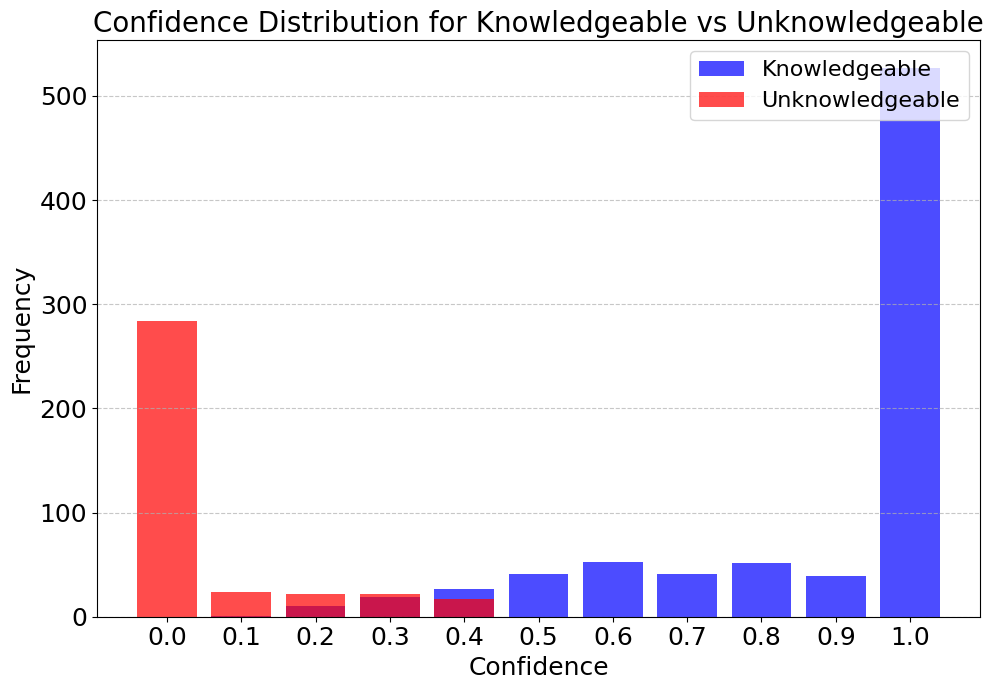

In [4]:
model_names = ["llama-3.2-1b", "llama-3.2-3b", "qwen-2.5-1.5b"]
task_names = ["code"]

data = []

for task in task_names:
    for model in model_names:
        with open(f"../data/eval_results/{task}/probe_evaluated/test_100_depth_4_{model}.pkl", "rb") as f:
            data.extend(pickle.load(f))

    
knowledgable_confidence = []
unknowledgable_confidence = []

for item in data:
    if item['knowledgable']:
        knowledgable_confidence.append(item['knowledge_confidence'])
    else:
        unknowledgable_confidence.append(item['knowledge_confidence'])

# --- Solution for discrete bins ---
# Your discrete values are 0, 0.1, 0.2, ..., 1.0 (11 distinct values).
# To center histogram bars on these values, we need bin edges halfway between them.
# For a value 'v', the bin should span from 'v - 0.05' to 'v + 0.05'.
# So, the edges will be: -0.05, 0.05, 0.15, ..., 0.95, 1.05.
# This creates 11 bins, each 0.1 wide.
bin_edges = np.arange(-0.05, 1.15, 0.1)
# print(f"Bin edges: {bin_edges}") # For verification: [-0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05]

plt.figure(figsize=(10, 7)) # Adjusted figure size for better readability

# Plot histogram for 'knowledgable_confidence'
plt.hist(knowledgable_confidence,
         bins=bin_edges,          # Use the custom bin edges
         alpha=0.7,               # Transparency
         label='Knowledgeable',
         color='blue',
         rwidth=0.8)              # Reduce bar width slightly to create small gaps if desired

# Plot histogram for 'unknowledgable_confidence'
plt.hist(unknowledgable_confidence,
         bins=bin_edges,          # Use the same custom bin edges
         alpha=0.7,               # Transparency
         label='Unknowledgeable',
         color='red',
         rwidth=0.8)              # Reduce bar width slightly

plt.title('Confidence Distribution for Knowledgeable vs Unknowledgeable', fontsize=20)
plt.xlabel('Confidence', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
# Tick font size
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Set x-axis ticks to be the center of the bins (your discrete values)
tick_centers = np.arange(0, 1.1, 0.1) # These are your actual discrete values: [0.  0.1 0.2 ... 1. ]
plt.xticks(tick_centers, [f"{x:.1f}" for x in tick_centers]) # Format ticks to one decimal place

plt.legend(loc='upper right', fontsize=16) # Legend for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid for easier frequency reading
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping
plt.show()

## Knowledge Injection Results

### Main Table

In [5]:
def is_answer_correct(item):
    return item["final_answer_correct"]

def is_reasoning_correct(item):
    return all([k['nli_class'] == 'entailment' for k in item['required_knowledge']])

def is_correct(item):
    return is_answer_correct(item) and is_reasoning_correct(item)

def rate(data, func):
    return sum([func(item) for item in data]) / len(data)

for task in task_names:
    for model in model_names:
        with open(f"../data/eval_results/{task}/injection_evaluated/original_100_depth_4_{model}_1.pkl", "rb") as f:
            original_data = pickle.load(f)

        with open(f"../data/eval_results/{task}/injection_evaluated/base_100_depth_4_{model}_1.pkl", "rb") as f:
            base_data_1 = pickle.load(f)

        with open(f"../data/eval_results/{task}/injection_evaluated/base_100_depth_4_{model}_10.pkl", "rb") as f:
            base_data_10 = pickle.load(f)

        with open(f"../data/eval_results/{task}/injection_evaluated/base_100_depth_4_{model}_100.pkl", "rb") as f:
            base_data_100 = pickle.load(f)
            
        print(f"Task: {task}")
        print(f"Model: {model}")
        print(f"Original: {rate(original_data, is_correct):.2f} (HP) {rate(original_data, is_answer_correct):.2f} (AP) {rate(original_data, is_reasoning_correct):.2f} (FKE)")
        print(f"Injection (KAS=1): {rate(base_data_1, is_correct):.2f} (HP) {rate(base_data_1, is_answer_correct):.2f} (AP) {rate(base_data_1, is_reasoning_correct):.2f} (FKE)")
        print(f"Injection (KAS=10): {rate(base_data_10, is_correct):.2f} (HP) {rate(base_data_10, is_answer_correct):.2f} (AP) {rate(base_data_10, is_reasoning_correct):.2f} (FKE)")
        print(f"Injection (KAS=100): {rate(base_data_100, is_correct):.2f} (HP) {rate(base_data_100, is_answer_correct):.2f} (AP) {rate(base_data_100, is_reasoning_correct):.2f} (FKE)")

Task: grow
Model: llama-3.2-1b
Original: 0.00 (HP) 0.23 (AP) 0.00 (FKE)
Injection (KAS=1): 0.12 (HP) 0.49 (AP) 0.24 (FKE)
Injection (KAS=10): 0.02 (HP) 0.24 (AP) 0.06 (FKE)
Injection (KAS=100): 0.00 (HP) 0.00 (AP) 0.00 (FKE)
Task: grow
Model: llama-3.2-3b
Original: 0.01 (HP) 0.25 (AP) 0.01 (FKE)
Injection (KAS=1): 0.52 (HP) 0.70 (AP) 0.56 (FKE)
Injection (KAS=10): 0.50 (HP) 0.61 (AP) 0.54 (FKE)
Injection (KAS=100): 0.33 (HP) 0.53 (AP) 0.36 (FKE)
Task: grow
Model: qwen-2.5-1.5b
Original: 0.00 (HP) 0.28 (AP) 0.00 (FKE)
Injection (KAS=1): 0.32 (HP) 0.68 (AP) 0.33 (FKE)
Injection (KAS=10): 0.28 (HP) 0.51 (AP) 0.32 (FKE)
Injection (KAS=100): 0.09 (HP) 0.39 (AP) 0.14 (FKE)
Task: code
Model: llama-3.2-1b
Original: 0.06 (HP) 0.11 (AP) 0.29 (FKE)
Injection (KAS=1): 0.09 (HP) 0.11 (AP) 0.27 (FKE)
Injection (KAS=10): 0.01 (HP) 0.01 (AP) 0.10 (FKE)
Injection (KAS=100): 0.00 (HP) 0.00 (AP) 0.00 (FKE)
Task: code
Model: llama-3.2-3b
Original: 0.17 (HP) 0.29 (AP) 0.41 (FKE)
Injection (KAS=1): 0.17 (HP

### Answer Pass and Full Knowledge Entailment


Processing model size: 1b
Attempting to load: ../data/eval_results/grow/injection_evaluated/original_100_depth_4_llama-3.2-1b_1.pkl
Successfully processed ../data/eval_results/grow/injection_evaluated/original_100_depth_4_llama-3.2-1b_1.pkl. Counts: {'AP&FKE': 0, 'AP&!FKE': 23, '!AP&FKE': 0, '!AP&!FKE': 77}
Attempting to load: ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-1b_1.pkl
Successfully processed ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-1b_1.pkl. Counts: {'AP&FKE': 12, 'AP&!FKE': 37, '!AP&FKE': 12, '!AP&!FKE': 39}
Attempting to load: ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-1b_10.pkl
Successfully processed ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-1b_10.pkl. Counts: {'AP&FKE': 2, 'AP&!FKE': 22, '!AP&FKE': 4, '!AP&!FKE': 72}
Attempting to load: ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-1b_100.pkl
Successfully processed ../data/e

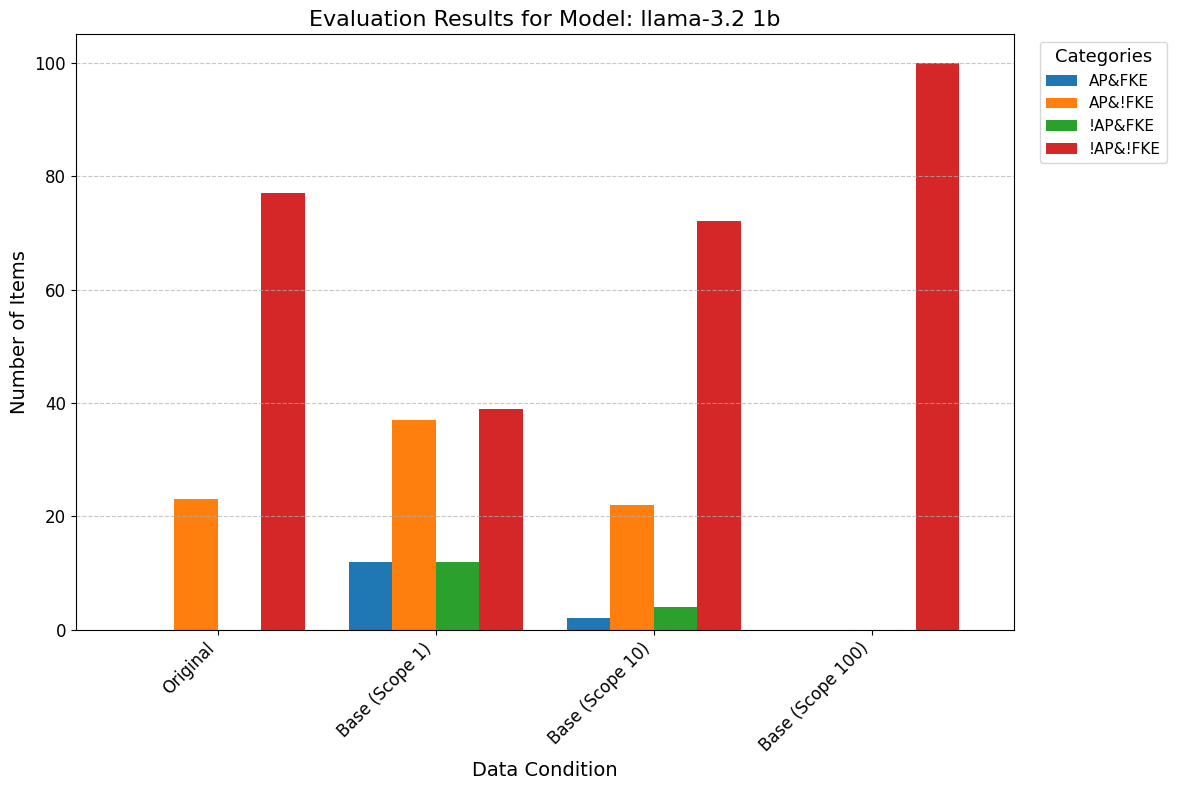

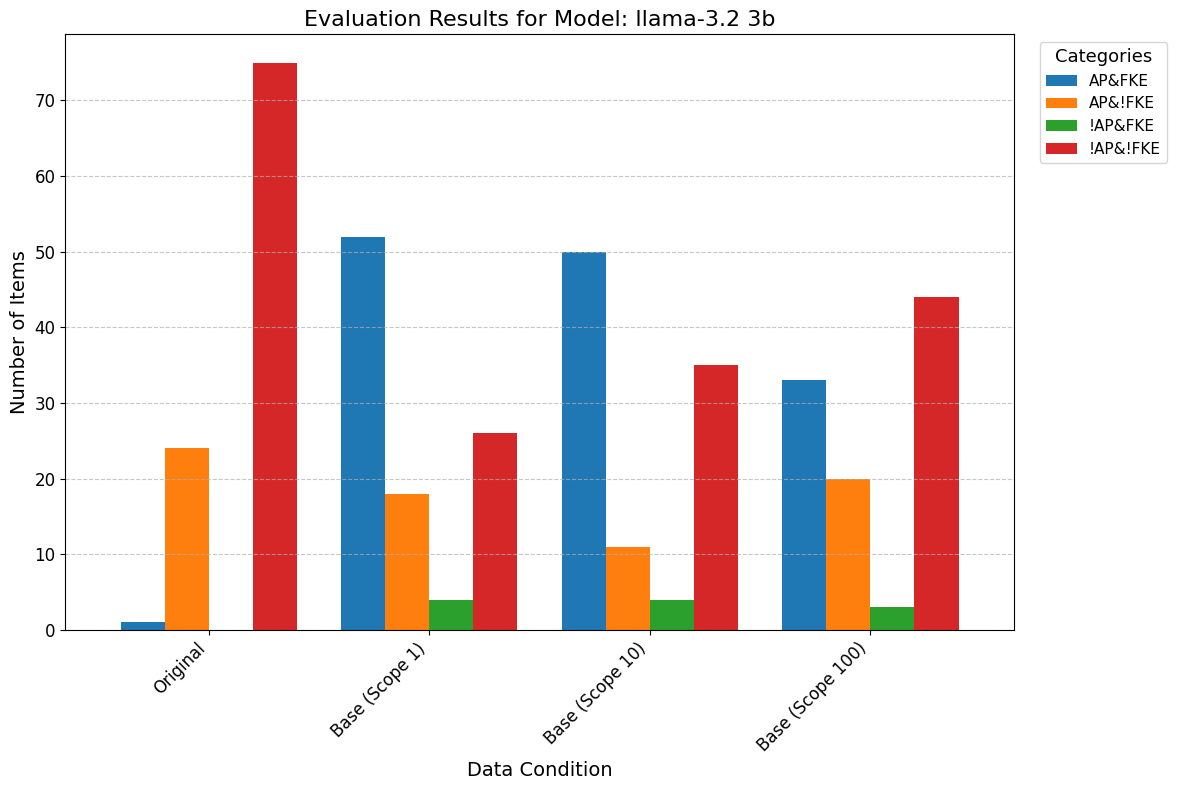

In [5]:
def get_category_counts(data_list, is_answer_correct_func, is_reasoning_correct_func):
    counts = {
        "AP&FKE": 0,  # Answer Correct, Reasoning Correct
        "AP&!FKE": 0,  # Answer Correct, Reasoning Wrong
        "!AP&FKE": 0, # Answer Incorrect, Reasoning Correct
        "!AP&!FKE": 0  # Answer Incorrect, Reasoning Incorrect
    }
    if not data_list: 
        return counts
        
    for item in data_list:
        if not isinstance(item, dict):
            print(f"Warning: Skipping item that is not a dictionary: {item}")
            continue

        ans_correct = is_answer_correct_func(item)
        reas_correct = is_reasoning_correct_func(item)

        if ans_correct and reas_correct:
            counts["AP&FKE"] += 1
        elif ans_correct and not reas_correct:
            counts["AP&!FKE"] += 1
        elif not ans_correct and reas_correct:
            counts["!AP&FKE"] += 1
        elif not ans_correct and not reas_correct:
            counts["!AP&!FKE"] += 1
    return counts

model_sizes = ["1b", "3b"]
all_plot_data = {} 

base_file_dir = "../data/eval_results/grow/injection_evaluated/"


for model_s in model_sizes:
    model_results_for_df = []
    datasets_to_load = [
        {"label": "Original", "type": "original", "scope_suffix": "_1"},
        {"label": "Base (Scope 1)", "type": "base", "scope_suffix": "_1"},
        {"label": "Base (Scope 10)", "type": "base", "scope_suffix": "_10"},
        {"label": "Base (Scope 100)", "type": "base", "scope_suffix": "_100"},
    ]

    print(f"\nProcessing model size: {model_s}")

    for dataset_info in datasets_to_load:
        if dataset_info["type"] == "original":
            file_name = f"original_100_depth_4_llama-3.2-{model_s}{dataset_info['scope_suffix']}.pkl"
        else: 
            file_name = f"base_100_depth_4_llama-3.2-{model_s}{dataset_info['scope_suffix']}.pkl"
        
        file_path = os.path.join(base_file_dir, file_name)
        
        print(f"Attempting to load: {file_path}")
        try:
            with open(file_path, "rb") as f:
                data = pickle.load(f)
            
            if not isinstance(data, list):
                print(f"Warning: Data in {file_path} is not a list. Skipping.")
                data = [] 

            category_counts = get_category_counts(data, is_answer_correct, is_reasoning_correct)
            row = {"Data Type": dataset_info["label"], **category_counts}
            model_results_for_df.append(row)
            print(f"Successfully processed {file_path}. Counts: {category_counts}")

        except FileNotFoundError:
            print(f"Warning: File not found: {file_path}. This dataset will have zero counts.")
            row = {"Data Type": dataset_info["label"], "AP&FKE": 0, "AP&!FKE": 0, "!AP&FKE": 0, "!AP&!FKE": 0}
            model_results_for_df.append(row)
        except Exception as e:
            print(f"Error loading or processing {file_path}: {e}. This dataset will have zero counts.")
            row = {"Data Type": dataset_info["label"], "AP&FKE": 0, "AP&!FKE": 0, "!AP&FKE": 0, "!AP&!FKE": 0}
            model_results_for_df.append(row)


    if model_results_for_df:
        df = pd.DataFrame(model_results_for_df)
        all_plot_data[model_s] = df
    else:
        print(f"No data rows generated for model {model_s}.")

# Plotting
plot_files = []
for model_s, df in all_plot_data.items():
    if df.empty:
        print(f"DataFrame for model {model_s} is empty. Skipping plot.")
        continue
    
    if df[["AP&FKE", "!AP&FKE", "AP&!FKE", "!AP&!FKE"]].sum().sum() == 0:
        print(f"No actual data (all counts are zero) for model {model_s}. A plot with all zeros will be generated if categories exist.")

    df.set_index("Data Type", inplace=True)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    df.plot(kind='bar', ax=ax, width=0.8)
    
    plt.title(f'Evaluation Results for Model: llama-3.2 {model_s}', fontsize=16)
    plt.ylabel('Number of Items', fontsize=14)
    plt.xlabel('Data Condition', fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Categories', title_fontsize='13', fontsize='11', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.show()

### Knowledge-Level Transition

In [6]:
def analyze_transitions(original_dataset, base_dataset, is_knowledgeable_filter):
    """
    Analyzes NLI label transitions between an original and a base dataset.
    Uses 'knowledgable' and 'nli_class' as keys.
    """
    transitions = {
        'entailment': defaultdict(int),
        'neutral': defaultdict(int),
        'contradiction': defaultdict(int),
        'unknown_original_label': defaultdict(int) 
    }
    possible_nli_labels = ['entailment', 'neutral', 'contradiction']

    if not original_dataset or not base_dataset:
        return transitions

    num_items = min(len(original_dataset), len(base_dataset))

    for i in range(num_items):
        item_orig = original_dataset[i]
        item_base = base_dataset[i]

        # Using 'required_knowledge' as per the initial problem description
        if 'required_knowledge' not in item_orig or 'required_knowledge' not in item_base:
            continue
            
        facts_orig = item_orig['required_knowledge']
        facts_base = item_base['required_knowledge']
        
        num_facts = min(len(facts_orig), len(facts_base))

        for j in range(num_facts):
            fact_orig = facts_orig[j]
            fact_base = facts_base[j]

            # MODIFIED KEYS HERE:
            if 'knowledgable' not in fact_orig or 'nli_class' not in fact_orig or 'nli_class' not in fact_base:
                # print(f"Warning: Missing 'knowledgable' or 'nli_class' in fact {j} of item {i}. Skipping fact.")
                continue

            # MODIFIED KEY HERE:
            if fact_orig['knowledgable'] == is_knowledgeable_filter:
                # MODIFIED KEYS HERE:
                original_nli = str(fact_orig['nli_class']).lower()
                base_nli = str(fact_base['nli_class']).lower()

                if original_nli in transitions:
                    transitions[original_nli][base_nli] += 1
                else:
                    transitions['unknown_original_label'][base_nli] += 1
                    if original_nli not in possible_nli_labels and original_nli != 'unknown_original_label':
                        # print(f"Warning: Encountered unexpected original NLI label '{original_nli}' (from 'nli_class') for fact {j} item {i}. Counted under 'unknown_original_label'.")
                        pass
                
                if base_nli not in possible_nli_labels and not any(char.isdigit() for char in base_nli):
                    # print(f"Info: Encountered base NLI label '{base_nli}' (from 'nli_class') not in {possible_nli_labels} for fact {j} item {i}. Original label was '{original_nli}'.")
                    pass

    return transitions

def merge_transition_dicts(agg_dict, new_dict):
    """Merges new_dict into agg_dict by summing counts."""
    for orig_label, base_label_counts in new_dict.items():
        if orig_label not in agg_dict:
            agg_dict[orig_label] = defaultdict(int)
        for base_label, count in base_label_counts.items():
            agg_dict[orig_label][base_label] += count

def print_transition_results(results, category_name_prefix, aggregated_models_list, aggregated_bases_list):
    """Prints the grand aggregated transition results."""
    full_category_name = f"{category_name_prefix} (Models: {', '.join(aggregated_models_list) if aggregated_models_list else 'None'}, Bases: {', '.join(aggregated_bases_list) if aggregated_bases_list else 'None'})"
    print(f"\n--- {full_category_name} ---")
    
    total_facts_in_category = 0
    found_data = False

    sorted_orig_labels = sorted(results.keys())

    for original_label in sorted_orig_labels:
        base_labels = results[original_label]
        if original_label == 'unknown_original_label' and not base_labels:
            continue
        
        current_label_total = sum(base_labels.values())
        if current_label_total > 0 or (original_label == 'unknown_original_label' and base_labels):
            found_data = True
            print(f"  From Original {original_label.capitalize()}:")
            for base_label, count in sorted(base_labels.items()):
                if count > 0:
                    print(f"    To Base {base_label.capitalize()}: {count}")
            if current_label_total > 0:
                 print(f"    Subtotal from Original {original_label.capitalize()}: {current_label_total}")
            total_facts_in_category += current_label_total
    
    if not found_data:
        print("    No facts found matching this category's criteria across all aggregated datasets.")
    else:
        print(f"  GRAND TOTAL facts considered in this category: {total_facts_in_category}")
    print("--------------------------------------------------")

# --- Main script ---

# STEP 1: Define model sizes and file structures
model_sizes_to_process = ["1b", "3b"]
all_loaded_data = {} 

data_file_structure = {
    "original": ("original_100_depth_4_llama-3.2-{model_size}_1.pkl", "original"),
    "base_1": ("base_100_depth_4_llama-3.2-{model_size}_1.pkl", "base_1"),
    "base_10": ("base_100_depth_4_llama-3.2-{model_size}_10.pkl", "base_10"),
    "base_100": ("base_100_depth_4_llama-3.2-{model_size}_100.pkl", "base_100")
}
base_path = "../data/eval_results/grow/injection_evaluated/" # Ensure this path is correct

print("--- Starting Data Loading ---")
successfully_loaded_models = []
for model_size in model_sizes_to_process:
    current_model_data = {}
    all_files_for_model_loaded = True
    for key_type, (name_template, data_key_in_dict) in data_file_structure.items():
        file_path = base_path + name_template.format(model_size=model_size)
        try:
            with open(file_path, "rb") as f:
                current_model_data[data_key_in_dict] = pickle.load(f)
            print(f"Successfully loaded: {file_path}")
        except FileNotFoundError:
            print(f"ERROR: File not found for model {model_size}, type {data_key_in_dict}: {file_path}.")
            all_files_for_model_loaded = False
            break 
        except Exception as e:
            print(f"ERROR loading file {file_path}: {e}.")
            all_files_for_model_loaded = False
            break
    
    if all_files_for_model_loaded:
        all_loaded_data[model_size] = current_model_data
        successfully_loaded_models.append(model_size)
    else:
        print(f"Model {model_size} will be SKIPPED for aggregation due to missing/corrupt files.")

if not successfully_loaded_models:
    print("\nNo data loaded successfully for ANY model. Exiting.")
    exit()
else:
    print(f"\n--- Data loading complete. Aggregating for models: {', '.join(successfully_loaded_models)} ---")

# STEP 2: Initialize Grand Aggregated Transition Counters
grand_aggregated_knowledgeable_transitions = {
    'entailment': defaultdict(int), 'neutral': defaultdict(int), 
    'contradiction': defaultdict(int), 'unknown_original_label': defaultdict(int)
}
grand_aggregated_unknowledgeable_transitions = {
    'entailment': defaultdict(int), 'neutral': defaultdict(int), 
    'contradiction': defaultdict(int), 'unknown_original_label': defaultdict(int)
}

base_data_keys_to_aggregate = ["base_1", "base_10", "base_100"] 
original_data_key = "original" 

# STEP 3: Perform Grand Aggregation
print("\n--- Starting Grand Aggregation Process ---")
for model_size in successfully_loaded_models:
    print(f"Processing model: {model_size}")
    if original_data_key not in all_loaded_data[model_size]:
        print(f"  Skipping model {model_size} as its original data ('{original_data_key}') is missing from loaded set.")
        continue
    current_original_data = all_loaded_data[model_size][original_data_key]

    for base_key in base_data_keys_to_aggregate:
        if base_key not in all_loaded_data[model_size]:
            print(f"  Skipping base dataset '{base_key}' for model {model_size} as it's missing from loaded set.")
            continue
        print(f"  Aggregating Original vs. {base_key} for model {model_size}")
        current_base_data = all_loaded_data[model_size][base_key]

        knowledgeable_segment = analyze_transitions(
            current_original_data, current_base_data, is_knowledgeable_filter=True
        )
        merge_transition_dicts(grand_aggregated_knowledgeable_transitions, knowledgeable_segment)

        unknowledgeable_segment = analyze_transitions(
            current_original_data, current_base_data, is_knowledgeable_filter=False
        )
        merge_transition_dicts(grand_aggregated_unknowledgeable_transitions, unknowledgeable_segment)
    print(f"Finished processing for model: {model_size}")


# STEP 4: Print Grand Aggregated Results
print(f"\n\n==============================================================")
print(f"GRAND AGGREGATED RESULTS")
print(f"==============================================================")

print_transition_results(grand_aggregated_knowledgeable_transitions,
                         "All 'Knowledgable' Facts - Aggregated", # Updated term
                         successfully_loaded_models,
                         base_data_keys_to_aggregate)

print_transition_results(grand_aggregated_unknowledgeable_transitions,
                         "All 'Unknowledgable' Facts - Aggregated", # Updated term
                         successfully_loaded_models,
                         base_data_keys_to_aggregate)

print("\n\n--- Grand Aggregation Complete ---")

--- Starting Data Loading ---
Successfully loaded: ../data/eval_results/grow/injection_evaluated/original_100_depth_4_llama-3.2-1b_1.pkl
Successfully loaded: ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-1b_1.pkl
Successfully loaded: ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-1b_10.pkl
Successfully loaded: ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-1b_100.pkl
Successfully loaded: ../data/eval_results/grow/injection_evaluated/original_100_depth_4_llama-3.2-3b_1.pkl
Successfully loaded: ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-3b_1.pkl
Successfully loaded: ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-3b_10.pkl
Successfully loaded: ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-3b_100.pkl

--- Data loading complete. Aggregating for models: 1b, 3b ---

--- Starting Grand Aggregation Process ---
Processing model: 1b
  Ag

### Instance-Level Transition

In [7]:
def classify_instance(item):
    """
    Classifies an instance (item) into one of three categories:
    AE (All Entailed), CP (Contradiction Present), MO (Mixed/Other).
    Uses 'nli_class' for NLI labels.
    """
    if 'required_knowledge' not in item or not item['required_knowledge']:
        # If no facts, consider it vacuously 'All Entailed' or a special category.
        # For now, AE seems reasonable as no facts violate the condition.
        return "AE"

    facts = item['required_knowledge']
    
    all_entailed = True
    has_contradiction = False

    for fact in facts:
        # Using 'nli_class' as requested
        nli_label = str(fact.get('nli_class', '')).lower()

        if nli_label == 'contradiction':
            has_contradiction = True
        
        if nli_label != 'entailment':
            all_entailed = False

    if all_entailed:
        return "AE"
    elif has_contradiction:
        return "CP"
    else:
        return "MO"

def print_instance_transition_results(transitions, aggregated_models, aggregated_bases):
    """Prints the instance-level transition matrix."""
    print(f"\n--- Instance-Level NLI Category Transitions ---")
    print(f"Aggregated for Models: {', '.join(aggregated_models) if aggregated_models else 'None'}")
    print(f"Aggregated for Base Versions: {', '.join(aggregated_bases) if aggregated_bases else 'None'}")
    print("-------------------------------------------------------------")
    
    categories = ["AE", "CP", "MO"]
    categories_desc = {
        "AE": "All Entailed",
        "CP": "Contradiction Present (and not AE)",
        "MO": "Mixed/Other (No contradictions, not AE)"
    }

    # Header
    header = f"{'From Original ↓':<20} | {'To Base →':<20} | "
    for cat in categories:
        header += f"{cat:<12} | "
    print(header.strip())
    print("-" * (len(header) -1)) # Adjust length for trailing space

    total_transitions = 0
    for orig_cat in categories:
        row_str = f"{categories_desc[orig_cat]:<20} ({orig_cat}) | "
        for base_cat in categories:
            count = transitions.get(orig_cat, {}).get(base_cat, 0)
            row_str += f"{count:<12} | "
            total_transitions += count
        print(row_str.strip())
    
    print("-" * (len(header) -1))
    print(f"Total instance comparisons considered: {total_transitions}")
    print("-------------------------------------------------------------")
    print("Category Definitions:")
    print("  AE (All Entailed): All 'required_knowledge' facts have 'nli_class' as 'entailment'.")
    print("  CP (Contradiction Present): Not AE, AND at least one fact has 'nli_class' as 'contradiction'.")
    print("  MO (Mixed/Other): Neither AE nor CP (e.g., mix of 'entailment'/'neutral', or all 'neutral').")


# --- Main script ---

# STEP 1: Define model sizes and file structures
model_sizes_to_process = ["1b", "3b"]
all_loaded_data = {} 

data_file_structure = {
    "original": ("original_100_depth_4_llama-3.2-{model_size}_1.pkl", "original"),
    "base_1": ("base_100_depth_4_llama-3.2-{model_size}_1.pkl", "base_1"),
    "base_10": ("base_100_depth_4_llama-3.2-{model_size}_10.pkl", "base_10"),
    "base_100": ("base_100_depth_4_llama-3.2-{model_size}_100.pkl", "base_100")
}
base_path = "../data/eval_results/grow/injection_evaluated/" # Ensure this path is correct

print("--- Starting Data Loading ---")
successfully_loaded_models = []
for model_size in model_sizes_to_process:
    current_model_data = {}
    all_files_for_model_loaded = True
    for key_type, (name_template, data_key_in_dict) in data_file_structure.items():
        file_path = base_path + name_template.format(model_size=model_size)
        try:
            with open(file_path, "rb") as f:
                current_model_data[data_key_in_dict] = pickle.load(f)
            print(f"Successfully loaded: {file_path}")
        except FileNotFoundError:
            print(f"ERROR: File not found for model {model_size}, type {data_key_in_dict}: {file_path}.")
            all_files_for_model_loaded = False
            break 
        except Exception as e:
            print(f"ERROR loading file {file_path}: {e}.")
            all_files_for_model_loaded = False
            break
    
    if all_files_for_model_loaded:
        all_loaded_data[model_size] = current_model_data
        successfully_loaded_models.append(model_size)
    else:
        print(f"Model {model_size} will be SKIPPED for aggregation due to missing/corrupt files.")

if not successfully_loaded_models:
    print("\nNo data loaded successfully for ANY model. Exiting.")
    exit()
else:
    print(f"\n--- Data loading complete. Aggregating for models: {', '.join(successfully_loaded_models)} ---")

# STEP 2: Initialize Instance-Level Transition Counters
instance_level_transitions = {
    "AE": defaultdict(int),
    "CP": defaultdict(int),
    "MO": defaultdict(int)
}

base_data_keys_to_aggregate = ["base_1", "base_10", "base_100"] 
original_data_key = "original" 

# STEP 3: Perform Instance-Level Aggregation
print("\n--- Starting Instance-Level Aggregation Process ---")
for model_size in successfully_loaded_models:
    print(f"Processing model: {model_size}")
    if original_data_key not in all_loaded_data[model_size]:
        print(f"  Skipping model {model_size} as its original data ('{original_data_key}') is missing.")
        continue
    
    original_items_list = all_loaded_data[model_size][original_data_key]

    for base_key in base_data_keys_to_aggregate:
        if base_key not in all_loaded_data[model_size]:
            print(f"  Skipping base dataset '{base_key}' for model {model_size} as it's missing.")
            continue
        
        print(f"  Aggregating Original vs. {base_key} for model {model_size} (Instance-Level)")
        base_items_list = all_loaded_data[model_size][base_key]
        
        num_items_to_compare = min(len(original_items_list), len(base_items_list))
        if len(original_items_list) != len(base_items_list):
            print(f"    Warning: Original ({len(original_items_list)}) and Base ({len(base_items_list)}) item lists have different lengths. Comparing up to {num_items_to_compare} items.")

        for i in range(num_items_to_compare):
            original_item = original_items_list[i]
            base_item = base_items_list[i]

            original_category = classify_instance(original_item)
            base_category = classify_instance(base_item)

            instance_level_transitions[original_category][base_category] += 1
            
    print(f"Finished instance-level processing for model: {model_size}")

# STEP 4: Print Instance-Level Aggregated Results
print(f"\n\n==============================================================")
print(f"OVERALL INSTANCE-LEVEL NLI CATEGORY TRANSITIONS")
print(f"==============================================================")

print_instance_transition_results(instance_level_transitions,
                                  successfully_loaded_models,
                                  base_data_keys_to_aggregate)

print("\n\n--- Instance-Level Aggregation Complete ---")

--- Starting Data Loading ---
Successfully loaded: ../data/eval_results/grow/injection_evaluated/original_100_depth_4_llama-3.2-1b_1.pkl
Successfully loaded: ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-1b_1.pkl
Successfully loaded: ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-1b_10.pkl
Successfully loaded: ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-1b_100.pkl
Successfully loaded: ../data/eval_results/grow/injection_evaluated/original_100_depth_4_llama-3.2-3b_1.pkl
Successfully loaded: ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-3b_1.pkl
Successfully loaded: ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-3b_10.pkl
Successfully loaded: ../data/eval_results/grow/injection_evaluated/base_100_depth_4_llama-3.2-3b_100.pkl

--- Data loading complete. Aggregating for models: 1b, 3b ---

--- Starting Instance-Level Aggregation Process ---
Processing model